<a href="https://colab.research.google.com/github/hkuennemann/Deep-Learning-PyTorch/blob/main/03_PyTorch_Computer_Vision/03_PyTorch_Computer_Vision_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision

Important computer vision libraries
- `torchvision`: base domain library for PyTorch computer vision
  - `torchvision.datasets`: get datasets and data loading functions for computer vision here
  - `torchvision.models`: get pretrained computer vision models taht you can leverage for your own problems
  - `torchvision.transforms`: functions for manipulating your vision data to be suitable for use with an ML model
  - `torch.utils.data.Dataset`: Base dataset class for PyTorch
  - `torch.utils.data.DataLoader`: Creates a Python iterable over a dataset


In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [ ]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting a dataset

In [ ]:
# Set up training data
train_data = datasets.FashionMNIST(
    root="data", # where to download the data to
    train=True, # do we want to get the train data
    download=True, # do we want to download
    transform=ToTensor(), # how do we want to transform the data
    target_transform=None # how do we want to transform the target / labels
)

test_data = datasets.FashionMNIST(
    root="data", # where to download the data to
    train=False, # do we want to get the train data
    download=True, # do we want to download
    transform=ToTensor(), # how do we want to transform the data
    target_transform=None # how do we want to transform the target / labels
)

In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
# See first training example
image, label = train_data[0]

In [ ]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [ ]:
# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Label shape: {label}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Label shape: 9


## 1.2 Visualizing our data

(-0.5, 27.5, 27.5, -0.5)

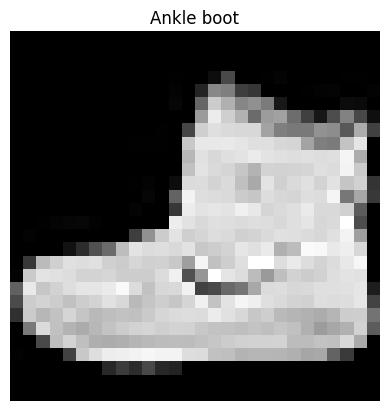

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(train_data.classes[label])
plt.axis("off")

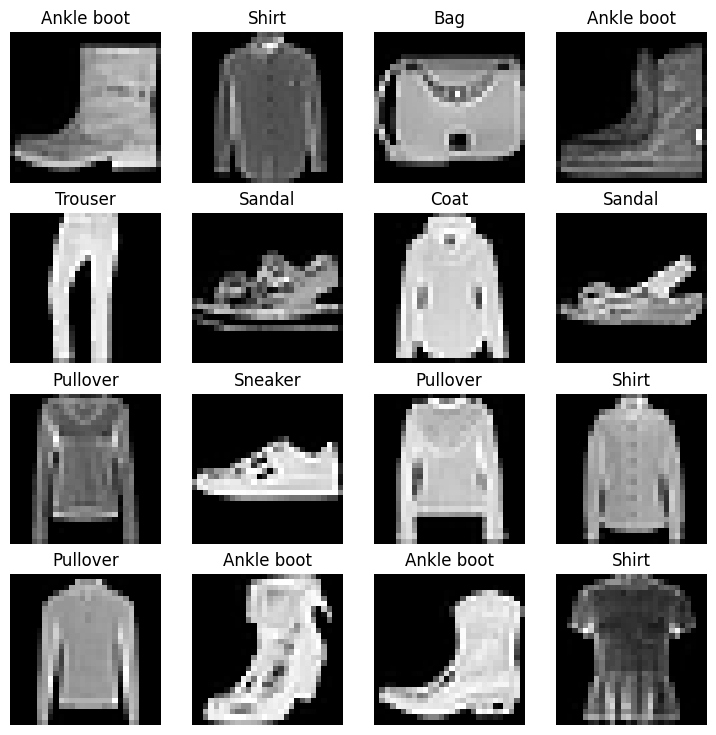

In [ ]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(train_data.classes[label])
    plt.axis(False)

## 2. Prepare DataLoader
Right now, our data is in the form of PyTorch Datasetes.

DataLoader turns our data into a Python iterable.

Most specifically, we want to turn our data into batches / mini-batches.

Why would we do this?
1. It is more computationally efficienct, as in you computing hardware may not be able to look (store in memory) at 60k images in one hit. So we break it down to 32 images at time.
2. It gives our nn more changes to update its gradients per epoch.

In [ ]:
# set up hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_Dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

test_Dataloader = torch.utils.data.DataLoader(dataset=test_data,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False) # For evaluation it is usually easier to NOT shuffle

print(train_Dataloader, test_Dataloader)
print(f"Length of train DataLoader: {len(train_Dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test Dataloader: {len(test_Dataloader)} batches of {BATCH_SIZE}...")

<torch.utils.data.dataloader.DataLoader object at 0x79303763c910> <torch.utils.data.dataloader.DataLoader object at 0x7930379de610>
Length of train DataLoader: 1875 batches of 32...
Length of test Dataloader: 313 batches of 32...


In [ ]:
# Check out what is inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_Dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Label: 6, Class: Shirt


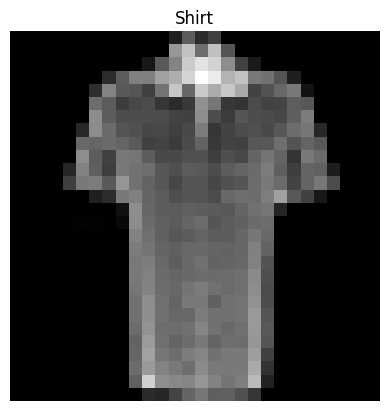

In [ ]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(train_data.classes[label])
plt.axis(False)
print(f"Label: {label}, Class: {train_data.classes[label]}")

## 3. Model 0: Build a baseline model

In [ ]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")

# Flatten the sample
x = flatten_model(x)
print(f"Shape after flattening: {x.shape} -> [color_channels, height * width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height * width]


In [ ]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):

        super().__init__()

        self.layer_stack = nn.Sequential(

            nn.Flatten(),

            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),

            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )
    def forward(self, x):
        return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape=784,
                             hidden_units=10,
                             output_shape=len(train_data.classes)).to("cpu")
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
dummy_x = torch.rand(size=(1, 1, 28, 28))
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function: `nn.CrossEntropyLoss()` -> multiclass classification
* Optimizer: `torch.optim.SGD()` -> stochastic gradient descent
* Evaluation metric: Accuracy

In [ ]:
import requests
from pathlib import Path

# Download helper functions from github repo
link = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py"
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(requests.get(link).content)

helper_functions.py already exists, skipping download


In [ ]:
# import accuracy metric
from helper_functions import accuracy_fn

# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                          lr=0.1)

### 3.2 Creating a function to time our experiments

Two main things you'll often want to track
- Model's performance (loss and accuracy values, etc.)
- How fast it runs

In [ ]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

start_time = timer()
# Some code...
end_time = timer()

print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


3.3692999750201125e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop trhough epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*
4. Print out what's happening
5. Time it all

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (keep this small for faster training time)
EPOCHS = 3

# Create training and test loop
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop through the training batches
    for batch, (X, y) in enumerate(train_Dataloader):
        model_0.train()

        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate the loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # NOTE: Parameters are updated ONCE PER BATCH!!!

        # Print out whats happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_Dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_Dataloader)

    ### Testing
    test_loss, test_acc = 0, 0

    # Put model in eval mode
    model_0.eval()
    with torch.inference_mode():
        # Loop through testing batches
        for X_test, y_test in test_Dataloader:
            # 1. Forward pass
            test_pred = model_0(X_test)

            # 2. Calculate the loss
            test_loss += loss_fn(test_pred, y_test)

            # 3. Calculate the accuracy
            test_acc += accuracy_fn(y_true=y_test,
                                    y_pred=test_pred.argmax(dim=1))

        # Calculate the test loss average per batch
        test_loss /= len(test_Dataloader)

        # Calculate the test accuracy average per batch
        test_acc /= len(test_Dataloader)

    # Print out what's happening
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                              end=train_time_end_on_cpu,
                                              device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.5904 | Test loss: 0.5095, Test acc: 82.0387
Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.4763 | Test loss: 0.4799, Test acc: 83.1969
Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.4550 | Test loss: 0.4766, Test acc: 83.4265
Train time on cpu: 33.366 seconds


## 4. Make predictions and get Model 0 results


In [ ]:
torch.manual_seed(42)

def eval_model(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()

  # Bring model to device
  model.to(device)

  # Turn on inference context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Bring data to device
      X, y = X.to(device), y.to(device)

      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_Dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 5. Setup device agnostic-code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1: Building a better model with non-linearity

In [ ]:
# Create a model with non-linear and linear layers

class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):

        super().__init__()

        self.layer_stack = nn.Sequential(

            nn.Flatten(),

            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),

            nn.ReLU(),

            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),

            nn.ReLU()
        )
    def forward(self, x):
        return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                             hidden_units=10,
                             output_shape=len(train_data.classes)).to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.1 Setup loss, optimizer and evaluation metics

In [ ]:
# Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                          lr=0.1)

### 6.2 Functionizing training and evaluation/testing loops

In [ ]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               accuracy_fn,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  """Trains a PyTorch model for a single epoch."""
  train_loss, train_acc = 0, 0

  model.to(device)

  # Put model on train
  model.train()

  # Add a loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    #Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulatively add up the loss per epoch
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Divide total train loss and accuracy by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}")

In [ ]:
def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Tests a PyTorch model for a single epoch."""

  ### Testing
  test_loss, test_acc = 0, 0

  # Put model on device
  model.to(device)

  # Put model in eval mode
  model.eval()

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through testing batches
    for X, y in data_loader:
      # Send data to device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate the loss
      test_loss += loss_fn(test_pred, y)

      # 3. Calculate the accuracy
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss and accuracy average per batch
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    # Print out what's happening
    print(f"\nTest loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_gpu = timer()

# Set the number of epochs (keep this small for faster training time)
EPOCHS = 3

# Create training and test loop
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_step(model=model_1,
               data_loader=train_Dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               optimizer=optimizer)

    ### Testing
    test_step(model=model_1,
              data_loader=test_Dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

# Calculate training time
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 1.09199 | Train acc: 61.34

Test loss: 0.95636, Test acc: 65.00
Epoch: 1
-------
Train loss: 0.78101 | Train acc: 71.93

Test loss: 0.72227, Test acc: 73.91
Epoch: 2
-------
Train loss: 0.67027 | Train acc: 75.94

Test loss: 0.68500, Test acc: 75.02
Train time on cuda: 26.736 seconds


Note: Sometimes the model trains faster on CPU than on GPU

Why is this?
- It could be that the overhead for copying data/model to and from the GPU outweighs the compute benefits offered by the GPU.
- The hardware you are using has a better CPU in terms of compute capability than the GPU (rare)

In [ ]:
# Get model_1 results dictionary
model_1_results = eval_model(model=model_1,
                             data_loader=test_Dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [ ]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 7. Model 2: Building a Convolutional Neural Network (CNN)

Good website for learner CNN: https://poloclub.github.io/cnn-explainer/

In [ ]:
# Create a convolutional neural networl
class FashionMNISTModelV2(nn.Module):
  def __init__(self,
                input_shape: int,
                hidden_units: int,
                output_shape: int):

    super().__init__()

    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.classier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units * 7 * 7,
                out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"Output shape of conv_block_1: {x.shape}")
    x = self.classier(x)
    #print(f"Output shape of classifier: {x.shape}")
    return x

In [ ]:
rand_image_tensor = torch.randn(size=(1, 28, 28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(train_data.classes)).to(device)

In [ ]:
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0409, -0.0763,  0.0726, -0.0432,  0.0035,  0.0332,  0.0071, -0.0078,
         -0.0165, -0.0116]], device='cuda:0', grad_fn=<AddmmBackward0>)

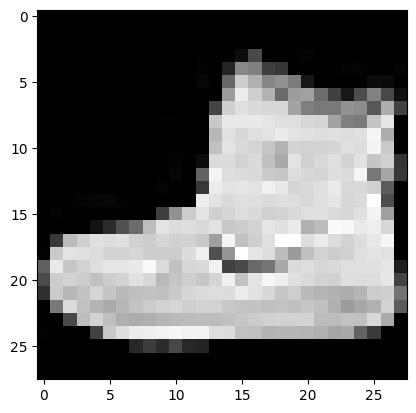

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")

### 7.1 Stepping through `nn.Conv2d()`

In [ ]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size = (32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.

In [ ]:
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 10,
                       kernel_size = 3,
                       stride = 1,
                       padding = 1)

conv_output = conv_layer(test_image)
conv_output

tensor([[[ 1.6446e-01, -6.2518e-01, -7.7713e-01,  ..., -3.2504e-01,
          -3.1604e-01,  4.5352e-01],
         [ 3.5455e-01, -2.8778e-01, -6.0596e-02,  ...,  6.6224e-01,
          -2.3216e-01,  7.7080e-01],
         [-4.5420e-02, -9.8911e-01, -4.0099e-01,  ..., -1.8552e-01,
          -5.7622e-01,  4.2301e-01],
         ...,
         [ 2.9288e-01, -1.4512e-01, -1.1566e-01,  ..., -3.6626e-01,
           3.5645e-01,  2.8384e-01],
         [ 2.0746e-01,  3.6096e-02,  1.5214e-01,  ..., -4.9680e-01,
          -7.2258e-01, -8.3858e-02],
         [-3.2457e-01, -3.2326e-01,  9.5475e-02,  ...,  5.9960e-01,
           3.2819e-01,  3.6604e-01]],

        [[ 1.2406e+00,  2.2794e-01, -1.8362e-01,  ..., -6.3520e-01,
          -7.5413e-01,  4.0612e-01],
         [ 4.1380e-01, -1.0853e+00, -1.6079e+00,  ..., -1.7643e+00,
           2.5263e-01,  3.8844e-01],
         [ 5.3442e-01, -8.2507e-01,  6.3866e-01,  ...,  4.8068e-01,
           8.4869e-01, -1.5706e-01],
         ...,
         [-5.6923e-03, -5

### 7.2 Stepping through `nn.MaxPool2d()`

In [ ]:
test_image.shape

torch.Size([3, 64, 64])

In [ ]:
# Print out original image shape without unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimensino: {test_image.unsqueeze(0).shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size = 2)

# Pass image through conv layer
test_image_through_conv = conv_layer(test_image.unsqueeze(0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass image through max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimensino: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 64, 64])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 32, 32])


In [ ]:
torch.manual_seed(42)

# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size = (1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size = 2)

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor}")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]])
Max pool tensor shape: torch.Size([1, 1, 1, 1])


### 7.3 Set up a loss function and optimizer

In [ ]:
# Setup loss function / evaluation metrics / optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

### 7.4 Training and Testing `model_2` using predefined functions

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
train_time_start_model_2 = timer()

# Set the number of epochs (keep this small for faster training time)
EPOCHS = 3

# Create training and test loop
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_step(model=model_2,
               data_loader=train_Dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               optimizer=optimizer)

    ### Testing
    test_step(model=model_2,
              data_loader=test_Dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

# Calculate training time
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.59228 | Train acc: 78.48

Test loss: 0.39525, Test acc: 85.73
Epoch: 1
-------
Train loss: 0.36276 | Train acc: 86.95

Test loss: 0.34216, Test acc: 87.33
Epoch: 2
-------
Train loss: 0.32384 | Train acc: 88.26

Test loss: 0.31600, Test acc: 88.35
Train time on cuda: 36.637 seconds


In [ ]:
# Get model_2 results
model_2_results = eval_model(model=model_2,
                             data_loader=test_Dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31599822640419006,
 'model_acc': 88.34864217252397}

In [ ]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 8. Compare model results and training time

In [ ]:
import pandas as pd

compare_results = pd.DataFrame(data = [model_0_results,
                                      model_1_results,
                                      model_2_results])

compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.315998,88.348642


In [ ]:
# Add training time to results comparison
compare_results["training_time"] = [f"{total_train_time_model_0:.3f}",
                                     f"{total_train_time_model_1:.3f}",
                                     f"{total_train_time_model_2:.3f}"]

compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,33.366
1,FashionMNISTModelV1,0.685001,75.019968,26.736
2,FashionMNISTModelV2,0.315998,88.348642,36.637


Text(0.5, 1.0, 'Model accuracy comparison')

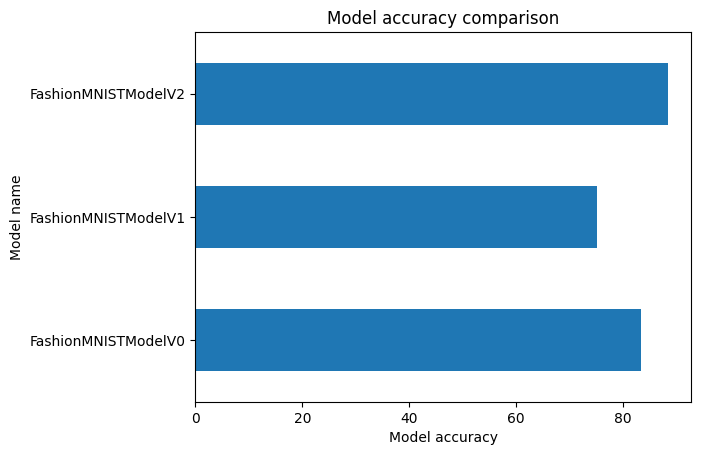

In [ ]:
# Visulaize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("Model accuracy")
plt.ylabel("Model name")
plt.title("Model accuracy comparison")

## 9. Make and evaluate random predictions with best model

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass
      pred_logit = model(sample)

      # Get prediction probability
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [ ]:
import random
#random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'T-shirt/top')

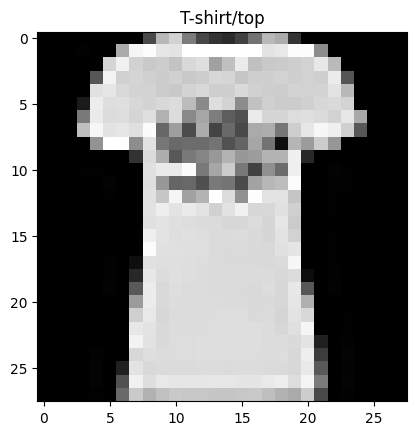

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(train_data.classes[test_labels[0]])

In [ ]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View first two prediction probabilities
pred_probs[:2]

tensor([[9.9582e-01, 3.7149e-07, 1.9736e-04, 1.4798e-04, 1.9658e-07, 2.4092e-09,
         3.8328e-03, 8.0867e-09, 2.4453e-06, 1.2586e-09],
        [5.9189e-04, 3.9932e-05, 1.5910e-02, 1.0127e-03, 5.5540e-01, 4.9792e-06,
         4.2640e-01, 3.7774e-07, 6.2670e-04, 1.7671e-05]])

In [ ]:
# Convert prediction probabilties to labels
pred_classes = pred_probs.argmax(dim=1)

pred_classes

tensor([0, 4, 6, 7, 6, 0, 3, 4, 2])

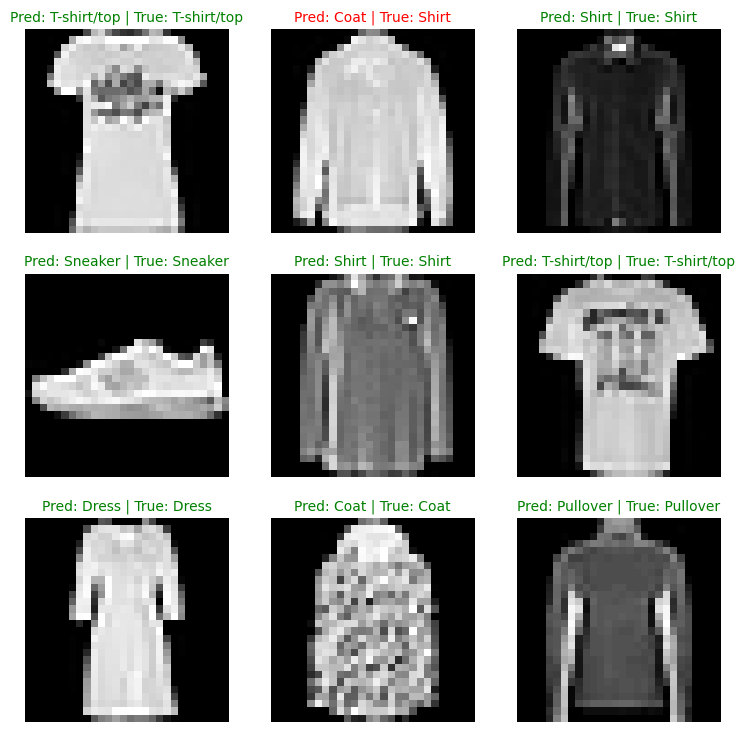

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))

nrows = 3
ncols = 3

for i, smaple in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the sample
  plt.imshow(smaple.squeeze(), cmap="gray")

  # Find the prediction
  pred_label = train_data.classes[pred_classes[i]]

  # Get the true label
  true_label = train_data.classes[test_labels[i]]

  # Set the title
  title_text = f"Pred: {pred_label} | True: {true_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == true_label:
    plt.title(title_text, fontsize = 10, c="g")
  else:
    plt.title(title_text, fontsize = 10, c="r")

  # Remove ticks
  plt.axis("off")

## 10. Making a confusion matrix for further prediction evaluation

1. Make predictions with our trained model on the test dataset
2. Make a confusion matrix `torchmetrics.ConfusionMatrix`
3. Plot the confusion matrix with `mlxtend.plotting.plot_confusion_matrix()`

In [ ]:
from tqdm.auto import tqdm
import mlxtend

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_Dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do forward pass
    y_logits = model_2(X)
    #Turn predictions from logits -> pred probabilities -> pred labels
    y_pred = torch.softmax(y_logits.squeeze(), dim=1).argmax(dim=1)
    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 5])

In [ ]:
len(y_pred_tensor)

10000

In [ ]:
# install torchmetrics
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

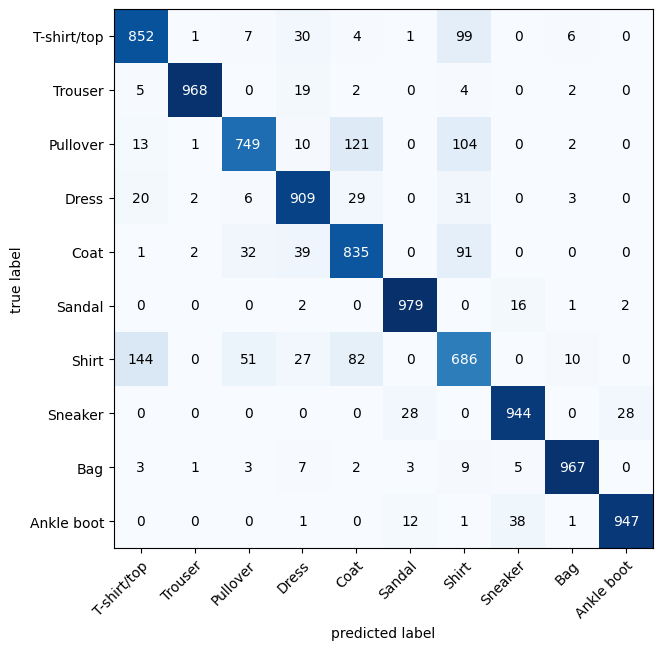

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task='multiclass', num_classes = len(train_data.classes))
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),
                                class_names = train_data.classes,
                                figsize = (10, 7))

## 11. Save and load best performing model

In [ ]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_2.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [ ]:
image_shape = [1, 28, 28]

In [ ]:
# Create a new instance
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape = 1,
                                     hidden_units = 10,
                                     output_shape = len(train_data.classes)).to(device)

# Load in the save state_dict()
loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))

<ipython-input-125-9ce85faf1d4b>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31599822640419006,
 'model_acc': 88.34864217252397}

In [ ]:
# Evaluate the model
loaded_model_2_results = eval_model(model=loaded_model_2,
                                    data_loader=test_Dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31599822640419006,
 'model_acc': 88.34864217252397}

In [ ]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_results['model_loss']),
              torch.tensor(loaded_model_2_results['model_loss']),
              atol=0.01)

tensor(True)